# Solving the binary paint shop problem with QAOA
**Using Fire Opal's QAOA solver to find solutions to the binary paint shop problem on real hardware**

Quantum Approximate Optimization Algorithm (QAOA) is a popular algorithm that can be applied to a wide range of optimization problems. One such optimization problem that can be solved using QAOA is the binary paint shop problem (BPSP). In this application note, we demonstrate how to solve BPSP using Fire Opal's easy-to-use [QAOA solver](https://docs.q-ctrl.com/fire-opal/topics/fire-opals-qaoa-solver) which handles all aspects of the execution of the algorithm with a single function call to optimize for the best performance on real hardware devices.

This application note covers the following:
* An introduction to BPSP and its real world applications.
* The derivation of the cost function required to solve BPSP using Fire Opal's QAOA solver.
* Execution of the solver.
* Analysis of the results and conclusions.

***
*Some cells in this notebook require an account with IBM-Q to execute correctly. If you want to run them, please go to the [IBM-Q experience](https://quantum-computing.ibm.com/login) to set up an account.*
***

## 1. Introduction
### 1.1 Problem definition
BPSP is an optimization problem that arises in the context of an automotive paint shop but can also be applied to a variety of industries including printing and textile manufacturing. The paint shop is given a sequence of cars where each car appears exactly twice. A car must be painted with two different colors of paint. The goal is to determine the optimal order in which to paint the cars to minimize the total number of color changes, as the color change procedure is costly in terms of time and resources. This problem is known to be NP-complete and APX-hard. This means finding the optimal solution requires exponential time, and no approximation algorithm exists with a constant approximation ratio. [Recent work](https://arxiv.org/pdf/2011.03403.pdf) has demonstrated how QAOA can be used to find solutions for BPSP and, with constant depth, is able to beat classical heuristics in the infinite problem size limit.

Let's denote the set of $n$ cars which should each be painted twice as $\Omega = \{c_0, c_1, ..., c_{n-1}\}$. A single instance of BPSP is given by a sequence $W = (w_0, . . ., w_{2n-1})$ with $w_i \in \Omega$, where each car, $c_i$, appears exactly twice. In practice, this sequence is fixed by contraints posed by the remaining manufacturing processes which are out of the shop's control, such as scheduling due to customer demand. We are given two colors $C = \{0,1\}$ and asked to find a coloring sequence $f = f_0, ... f_{2n-1}$, where $f_i \in C$, which minimizes the number of color changes between two consecutive cars in the given sequence. Without loss of generality, we will also fix the first color of the first car, $c_0$, to $0$.

### 1.2 Deriving the cost
To solve this problem using QAOA we start by assigning binary variables to each car where the value of the variable represents the paint color. We denote $0$ as red (🚗) and $1$ as blue (🚙). Then a solution to the problem is given by a paint bitstring, $[x[1], ..., x[n-1]]$, with $x[i] \in C$, which defines the first paint color for car $c_i$. In the paint bitstring encoding, $x[i]=0$ if the car is painted red the first time it appears in the sequence, and blue otherwise. $x[0]$ is removed from the bitstring as car $c_0$ must be assigned to $0$. For every car in our car sequence, $W$, we need to check if the car is being painted for the first or second time and build up the color sequence, $f$, accordingly. Then we can count the number of times the paint color changes for $f$ and find the paint bitstring where this is minimal. In other words, we want to find a paint bitstring which minimizes $$ \Delta_C = \sum_i |f_i - f_{i+1}|. $$

For example, say our car sequence is equal to $(1, 0, 1, 2, 0, 2)$. The set of possible solutions is $00, 01, 10, 11$, based on the two decision variables $x_1$ and $x_2$ for cars $c_1$ and $c_2$, respectively. The paint bitstring $10$ produces the color sequence $f$ = 🚗 🚗 🚙 🚙 🚙 🚗. This corresponds to 2 paint color changes. We can verify that the solution, $10$, is optimal by calculating the number of color changes for all $2^{n-1}$ possible paint bitstrings. In this 3 car example, we find 2 optimal bitstrings, including $10$. $01$, resulting in the color sequence $f$ = 🚙 🚗 🚗 🚗 🚙 🚙, is also part of the optimal solution set.

### 1.3 Using Fire Opal's `solve_qaoa`
Fire Opal’s `solve_qaoa` function alleviates the complexity of running QAOA algorithms by providing a single function that performs the entire execution process. To use `solve_qaoa`, we only need to specify a polynomial cost function represented as a SymPy [`expr`](https://docs.sympy.org/latest/modules/core.html#module-sympy.core.expr).

In order to formulate the cost function, counting the number of colour changes, as a polynomial, we will take $$ |f_i - f_{i+1}| = (f_i - f_{i+1})^2 $$

## 2. Imports and initialization
The following section sets up the necessary imports and helper functions.

In [1]:
import fireopal
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sympy import symbols, Float, symarray
from qctrlvisualizer import QCTRL_STYLE_COLORS

In [2]:
def car_seq_to_color_seq(car_seq, paint_bitstring):
    """
    Find the resulting `color_sequence` for the given `car_seq` and `paint_bitstring`.
    """
    painted_once = set()
    color_sequence = []
    paint_bitstring = paint_bitstring + "0"

    for car in car_seq:
        if car in painted_once:
            color_sequence.append(1 - int(paint_bitstring[-(car + 1)]))
        else:
            color_sequence.append(int(paint_bitstring[-(car + 1)]))
            painted_once.add(car)
    return color_sequence


def color_seq_to_emoji_str(color_sequence):
    """
    Convert a `color_sequence` to a string of emojis.
    """
    emoji_map = {1: "\N{recreational vehicle}", 0: "\N{automobile}"}
    emoji_str = ""
    for car in color_sequence:
        emoji_str += emoji_map[car]
    return emoji_str

## 3. Setting up the problem
The following section involves the problem setup and creation of the cost function.

### 3.1 Setting up credentials for Fire Opal
We will need to set up our IBM account credentials in order to solve our problem on real hardware using Fire Opal.

In [3]:
# Set credentials.
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"

credentials = fireopal.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

# Replace "your_desired_backend" with the name of the device you wish to use.
# Run fireopal.show_supported_devices(credentials) to get a list of suppported backend names.
backend_name = "your_desired_backend"

### 3.2 Defining the problem instance
The problem instance will be a randomly generated permutation of 7 cars, each repeated exactly twice.

In [22]:
car_count = 7
car_sequence = np.random.permutation([x for x in range(car_count)] * 2)
print(f"Randomly generated car sequence to solve for {car_count} cars: {car_sequence}")

Randomly generated car sequence to solve for 7 cars: [4 2 6 3 3 4 1 1 0 5 0 6 2 5]


### 3.3 Defining the cost function
The cost function must be expressed as a polynomial cost function represented as a SymPy `expr`.

In [23]:
def car_sequence_to_cost_polynomial(sequence):
    variables = symarray("x", len(sequence) // 2)
    painted_once = set()
    color_sequence = []
    variables[0] = 0
    for car in sequence:
        if car in painted_once:
            color_sequence.append(1 - variables[car])
        else:
            color_sequence.append(variables[car])
            painted_once.add(car)
    paint_change_counter = Float(0)
    for c0, c1 in zip(color_sequence, color_sequence[1:]):
        paint_change_counter += (c0 - c1) ** 2
    return variables, paint_change_counter


decision_variables, cost_polynomial = car_sequence_to_cost_polynomial(car_sequence)
print(f"The polynomial cost expression: {cost_polynomial}")

The polynomial cost expression: x_5**2 + x_6**2 + (1 - x_1)**2 + (2*x_1 - 1)**2 + (-x_2 + x_4)**2 + (-x_2 + x_5)**2 + 2*(x_2 - x_6)**2 + (-x_3 + x_4)**2 + (-x_3 + x_6)**2 + (2*x_3 - 1)**2 + (x_5 - 1)**2 + (-x_1 - x_4 + 1)**2


## 4. Running the algorithm


In [26]:
fire_opal_solution = fireopal.solve_qaoa(
    problem=cost_polynomial, credentials=credentials, backend_name=backend_name
)
solution_bitstring = fire_opal_solution["solution_bitstring"]
solution_sequence = car_seq_to_color_seq(car_sequence, solution_bitstring)

In [27]:
print(
    f"\nAn optimized paint bitstring is {solution_bitstring}\n"
    f"resulting in a color sequence {color_seq_to_emoji_str(solution_sequence)}\n"
    f"which requires {sum([np.abs(c0 - c1) for c0, c1 in zip(solution_sequence, solution_sequence[1:])])} paint color changes."
)


An optimized paint bitstring is 000001
resulting in a color sequence 🚗🚗🚗🚗🚙🚙🚙🚗🚗🚗🚙🚙🚙🚙
which requires 3 paint color changes.


## 5. Confirming the solution
For a small number of cars, we can manually calculate the number of paint color changes for every possible bitstring, and confirm that the solution found by `solve_qaoa` is optimized. In fact, looking at the final bitstring distribution returned by `solve_qaoa`, we can see that all optimal solutions were found with similar probabilities. It is straightforward to visualize each optimal solution to see that we have found the optimal number bitstring with the least amount of paint color changes.

In [28]:
brute_force_solution = []
possible_solutions = ["".join(x) for x in itertools.product("01", repeat=car_count - 1)]

for solution_bitstring in possible_solutions:
    paint_change_counter = 0
    color_sequence = car_seq_to_color_seq(car_sequence, solution_bitstring)
    color_sequence
    for c0, c1 in zip(color_sequence, color_sequence[1:]):
        paint_change_counter += np.abs(c0 - c1)
    brute_force_solution.append((solution_bitstring, paint_change_counter))
optimal_change_count = min(brute_force_solution, key=lambda t: t[1])[1]
optimal_bitstrings = [
    bitstring
    for bitstring, count in brute_force_solution
    if count == optimal_change_count
]

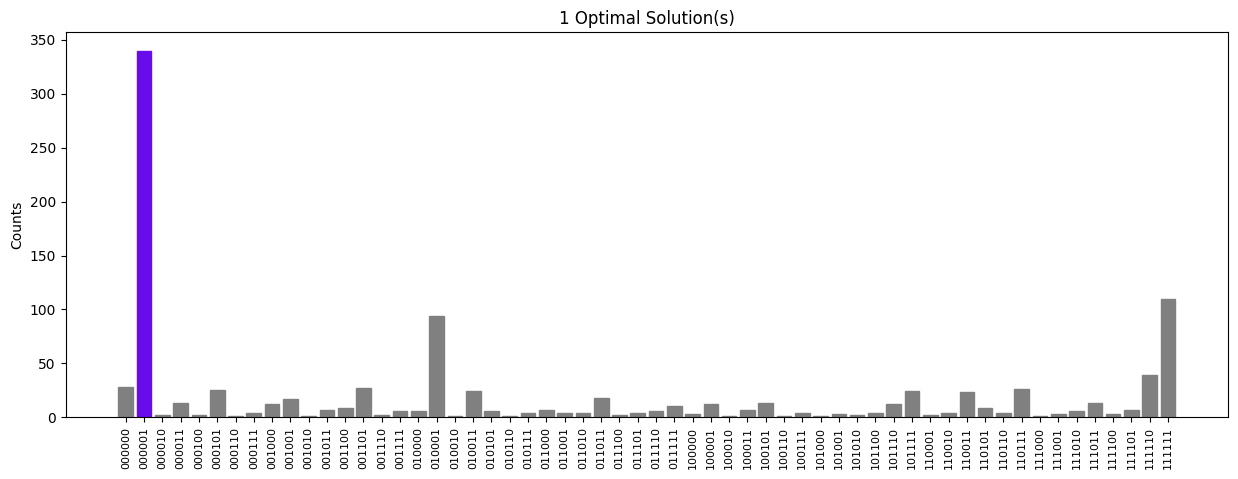

In [29]:
def plot_histogram(distribution, title=""):
    """Plot the counts distribution"""
    bitstrings, counts = zip(
        *sorted(distribution.items(), key=lambda item: item[0], reverse=False)
    )

    plt.figure(figsize=(15, 5))
    bars = plt.bar(bitstrings, counts)
    plt.xticks(rotation=90, ha="center", fontsize=8)

    for index, bitstring in enumerate(bitstrings):
        if bitstring not in optimal_bitstrings:
            bars[index].set_color("grey")
        else:
            bars[index].set_color(QCTRL_STYLE_COLORS[0])

    plt.ylabel("Counts")
    plt.title(title)
    plt.show()


plot_histogram(
    fire_opal_solution["final_bitstring_distribution"],
    f"{int(len(optimal_bitstrings))} Optimal Solution(s)",
)

In [30]:
for bitstring in optimal_bitstrings:
    print(
        bitstring, color_seq_to_emoji_str(car_seq_to_color_seq(car_sequence, bitstring))
    )

000001 🚗🚗🚗🚗🚙🚙🚙🚗🚗🚗🚙🚙🚙🚙


Here we observe that each of the optimal solution set computed classically matches what was found by the QAOA solver when ran on a real hardware device.

The package versions below were used to produce this notebook.

In [2]:
from fireopal import print_package_versions

print_package_versions()

| Package          | Version |
| ---------------- | ------- |
| Python           | 3.11.3  |
| matplotlib       | 3.7.1   |
| networkx         | 2.8.8   |
| numpy            | 1.23.5  |
| sympy            | 1.12    |
| fire-opal        | 5.3.1   |
| qctrl-visualizer | 6.0.0   |
